## 1. Preparation
### 1.1 Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Matplotlib is building the font cache; this may take a moment.


### 1.2 Import Data

In [9]:
# Parameters
data = pd.read_csv("data/data.csv")

# Signal file mapping
signal_files = {
    "J68894_420R": "data/J68894_420R/signal.csv",
    "J3929_450R": "data/J3929_450R/signal.csv",
    "F21329": "data/F21329/signal.csv",
    "J0636_446R": "data/J0636_446R/signal.csv",
    "F15021": "data/F15021/signal.csv",
    "J64906_406R": "data/J64906_406R/signal.csv",
    "J66248_407R": "data/J66248_407R/signal.csv",
    "J532296_502R": "data/J532296_502R/signal.csv",
}

# Load all signals into a dictionary
signals = {key: pd.read_csv(Path(path)) for key, path in signal_files.items()}

## 2. Data Analysis
### 2.1 Display One Signal

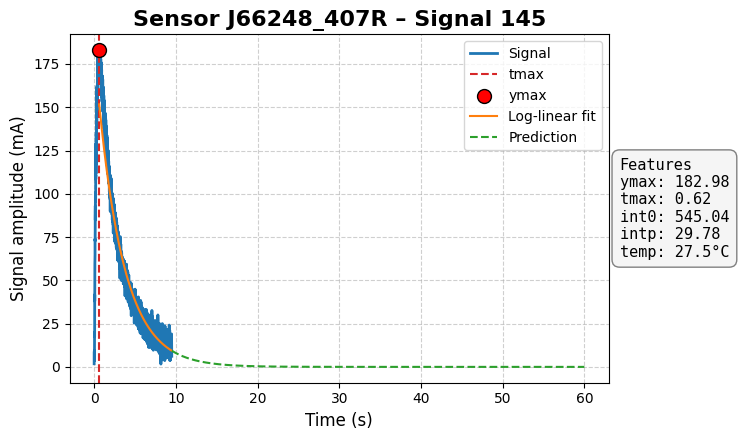

In [ ]:
def plot_signal_with_fit(df, signals_dict, sensor, signal, t_max=180):
    """
    Plot a signal from a given sensor with a log-linear decay fit and prediction.

    Parameters:
    - df (pd.DataFrame): Metadata DataFrame containing sensor, sig, ymax, tmax, temp, etc.
    - signals_dict (dict): Dictionary mapping "data_signals_X" -> DataFrame with signal data.
    - sensor (int): Sensor ID (matches the number in 'data_signals_X')
    - signal (int): Signal ID to plot
    - t_max (float): Maximum time for prediction (seconds)
    """
    # Extract signal data from the dictionary
    signals_df = signals_dict[sensor]
    signal_data = signals_df[signals_df['sig'] == signal]

    if signal_data.empty:
        raise ValueError(f"No data found for sensor {sensor}, signal {signal}")

    # Extract metadata row
    meta_row = df[(df['sensor'] == sensor) & (df['sig'] == signal)]
    if meta_row.empty:
        raise ValueError(f"No metadata found for sensor {sensor}, signal {signal}")
    meta = meta_row.iloc[0]

    ymax, tmax, temp = meta['ymax'], meta['tmax'], meta['temp']

    # Full signal
    t = signal_data['t'].to_numpy()
    y = signal_data['y'].to_numpy()

    # Keep only positive values
    mask_positive = y > 0
    t = t[mask_positive]
    y = y[mask_positive]

    # Find time of max signal
    tmax_idx = np.argmax(y)
    tmax_val = t[tmax_idx]

    # Data for fitting (from tmax onward)
    t_fit = t[t >= tmax_val]
    y_fit = y[t >= tmax_val]
    log_y_fit = np.log(y_fit)

    # Linear regression in log-space
    model = LinearRegression(fit_intercept=True)
    model.fit(t_fit.reshape(-1, 1), log_y_fit)

    # Fit prediction for the known region
    log_y_fit_pred = model.predict(t_fit.reshape(-1, 1))
    y_fit_pred = np.exp(log_y_fit_pred)

    # Predict beyond the last measured time
    t_pred = np.arange(t[-1], t_max + 0.002, 0.002)
    log_y_pred = model.predict(t_pred.reshape(-1, 1))
    y_pred = np.exp(log_y_pred)

    # Integrals
    int_measured = np.trapezoid(y, t)
    int_predicted = np.trapezoid(y_pred, t_pred)
    int_total = int_measured + int_predicted

    # --- Plot ---
    plt.figure(figsize=(7.5, 4.5))
    plt.plot(t, y, label="Signal", color="tab:blue", linewidth=2)
    plt.axvline(tmax_val, color="tab:red", linestyle="--", label="tmax")
    plt.scatter(tmax_val, ymax, color="red", edgecolor="k", zorder=5, s=100, label="ymax")
    plt.plot(t_fit, y_fit_pred, color="tab:orange", label="Log-linear fit")
    plt.plot(t_pred, y_pred, color="tab:green", linestyle="--", label="Prediction")

    # Text box with features
    textstr = (
        f"Features\n"
        f"ymax: {ymax:.2f}\n"
        f"tmax: {tmax_val:.2f}\n"
        f"int0: {int_measured:.2f}\n"
        f"intp: {int_predicted:.2f}\n"
        f"temp: {temp:.1f}°C"
    )
    props = dict(boxstyle="round,pad=0.5", facecolor="whitesmoke", edgecolor="gray")
    plt.gca().text(1.02, 0.5, textstr, transform=plt.gca().transAxes, fontsize=11,
                   verticalalignment="center", bbox=props, family="monospace")

    plt.title(f"Sensor {sensor} – Signal {signal}", fontsize=16, weight="bold")
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Signal amplitude (mA)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Plot a specific signal
plot_signal_with_fit(data, signals, sensor='J66248_407R', signal=145, t_max=60)

### 2.2 Calibration Lines

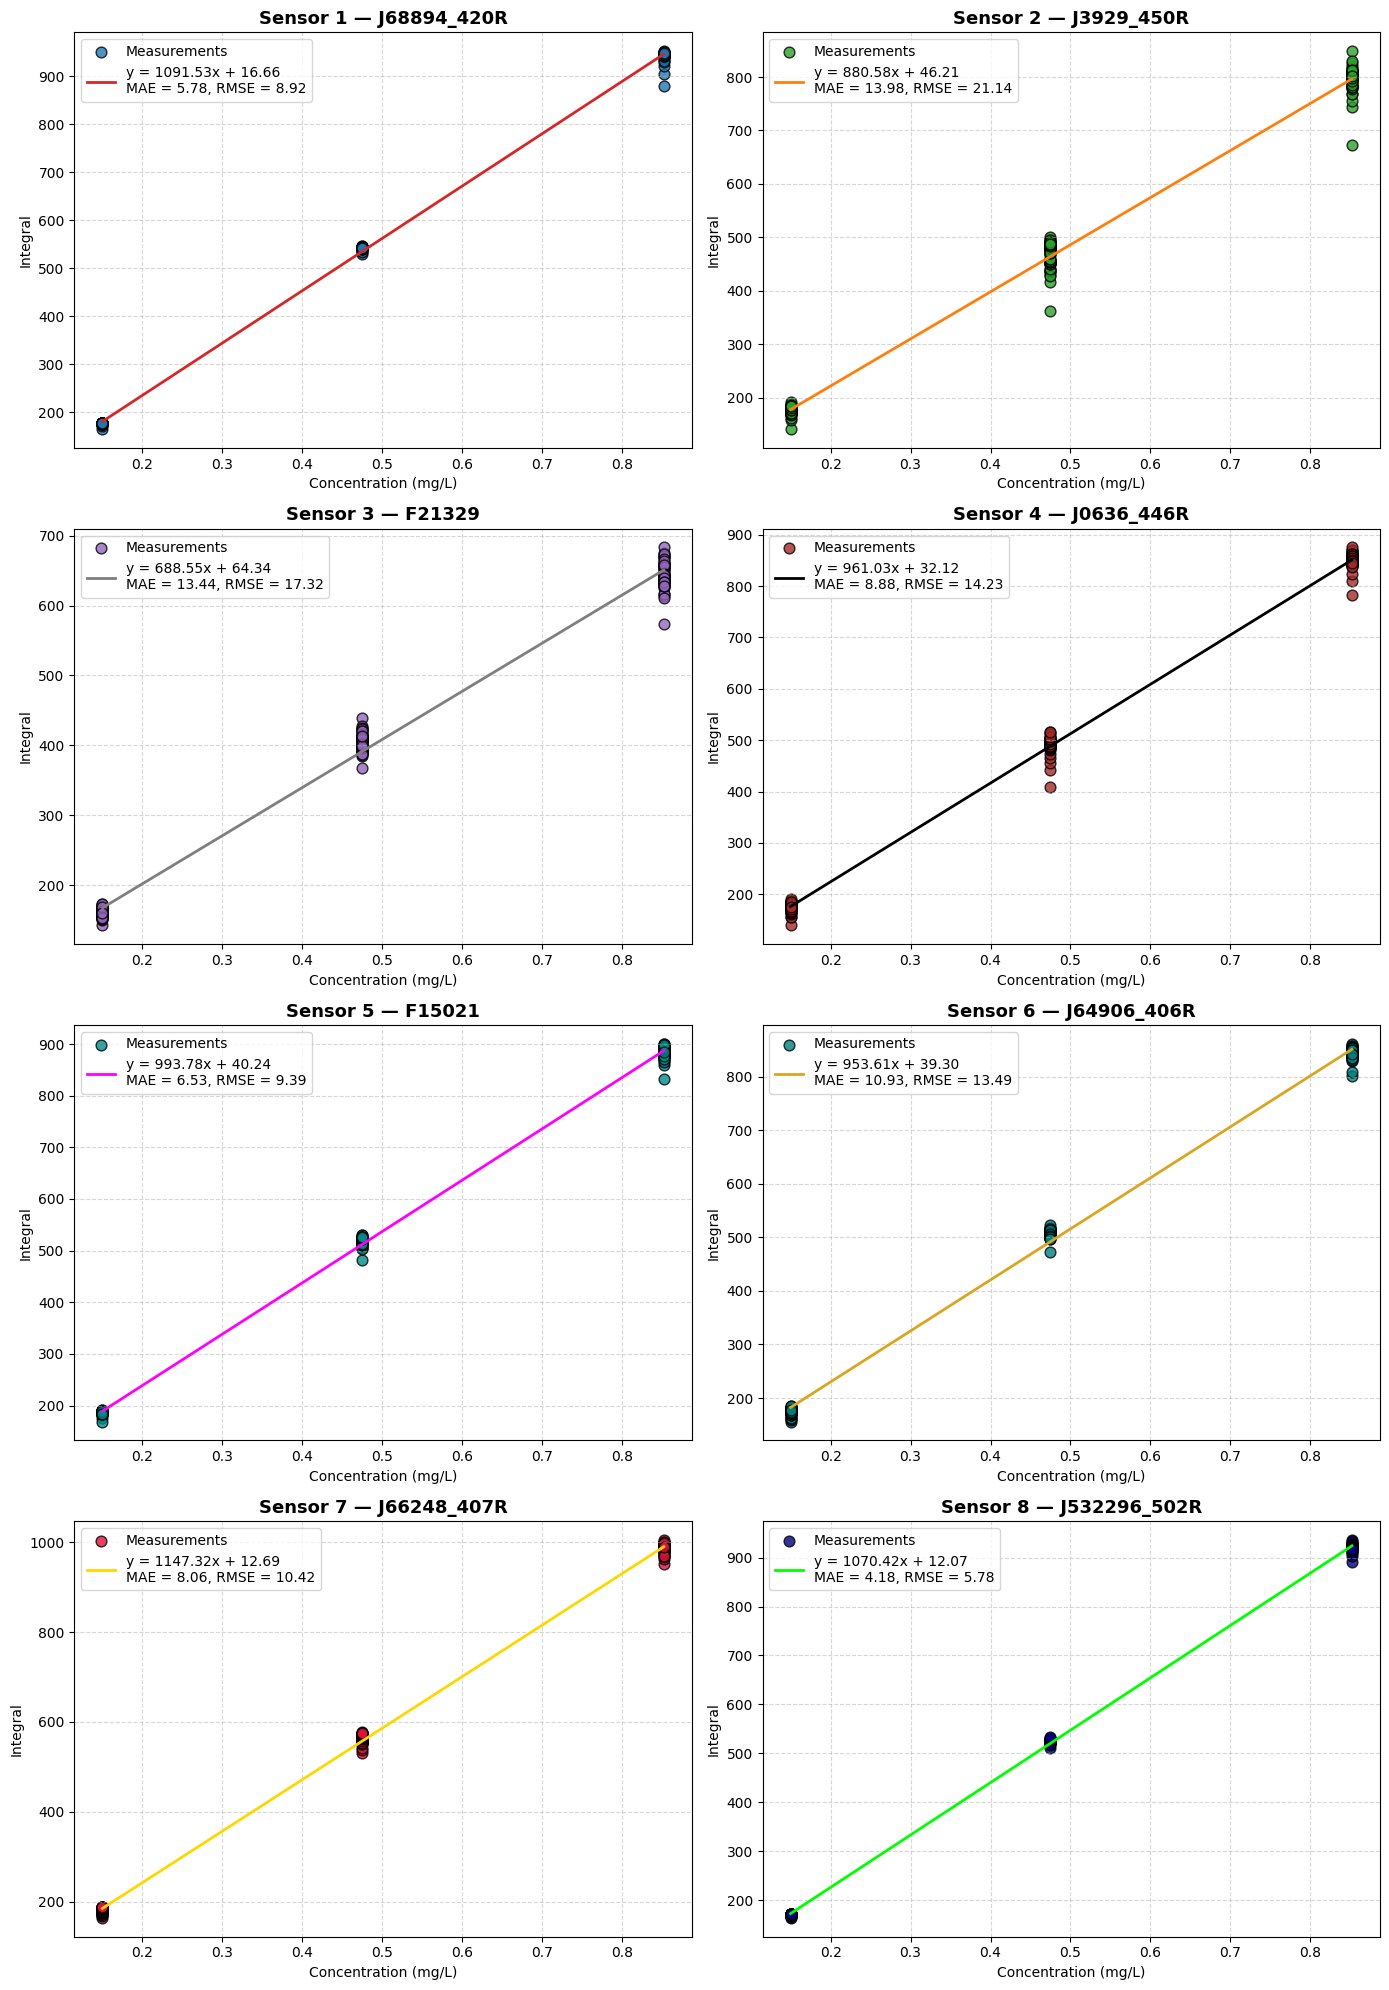

In [16]:
# Plot calibration curves for each sensor
fig, axes = plt.subplots(4, 2, figsize=(14, 20))
axes = axes.flatten()

# Colors: (scatter, line)
colors = [
    ('tab:blue', 'tab:red'),
    ('tab:green', 'tab:orange'),
    ('tab:purple', 'tab:gray'),
    ('brown', 'black'),
    ('darkcyan', 'magenta'),
    ('teal', 'goldenrod'),
    ('crimson', 'gold'),
    ('navy', 'lime')
]

# Map dataset keys to sensor IDs (1-based index)
sensor_keys = list(signal_files.keys())

for idx, sensor_key in enumerate(sensor_keys, start=1):
    ax = axes[idx - 1]
    sensor_data = data[data['sensor'] == sensor_key]

    scatter_color, line_color = colors[idx - 1]

    # Extract values
    conc = sensor_data['conc'].to_numpy()
    intnt = sensor_data['intnt'].to_numpy()
    intnt_calibr = sensor_data['intnt_calibr'].to_numpy()

    k = sensor_data['k'].iloc[0]
    b = sensor_data['b'].iloc[0]
    mae = sensor_data['mae'].iloc[0]
    rmse = sensor_data['rmse'].iloc[0]

    # Sort by concentration for a smooth calibration line
    sort_idx = conc.argsort()
    conc_sorted = conc[sort_idx]
    intnt_calibr_sorted = intnt_calibr[sort_idx]

    # Scatter plot
    ax.scatter(conc, intnt, label='Measurements',
               color=scatter_color, edgecolor='k', s=60, alpha=0.8)

    # Calibration line
    ax.plot(conc_sorted, intnt_calibr_sorted,
            label=f'y = {k:.2f}x + {b:.2f}\nMAE = {mae:.2f}, RMSE = {rmse:.2f}',
            color=line_color, linewidth=2)

    # Labels & styling
    ax.set_xlabel('Concentration (mg/L)')
    ax.set_ylabel('Integral')
    ax.set_title(f'Sensor {idx} — {sensor_key}', fontsize=13, weight='bold')
    ax.legend(frameon=True)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### 2.3 Compare sensors by signals

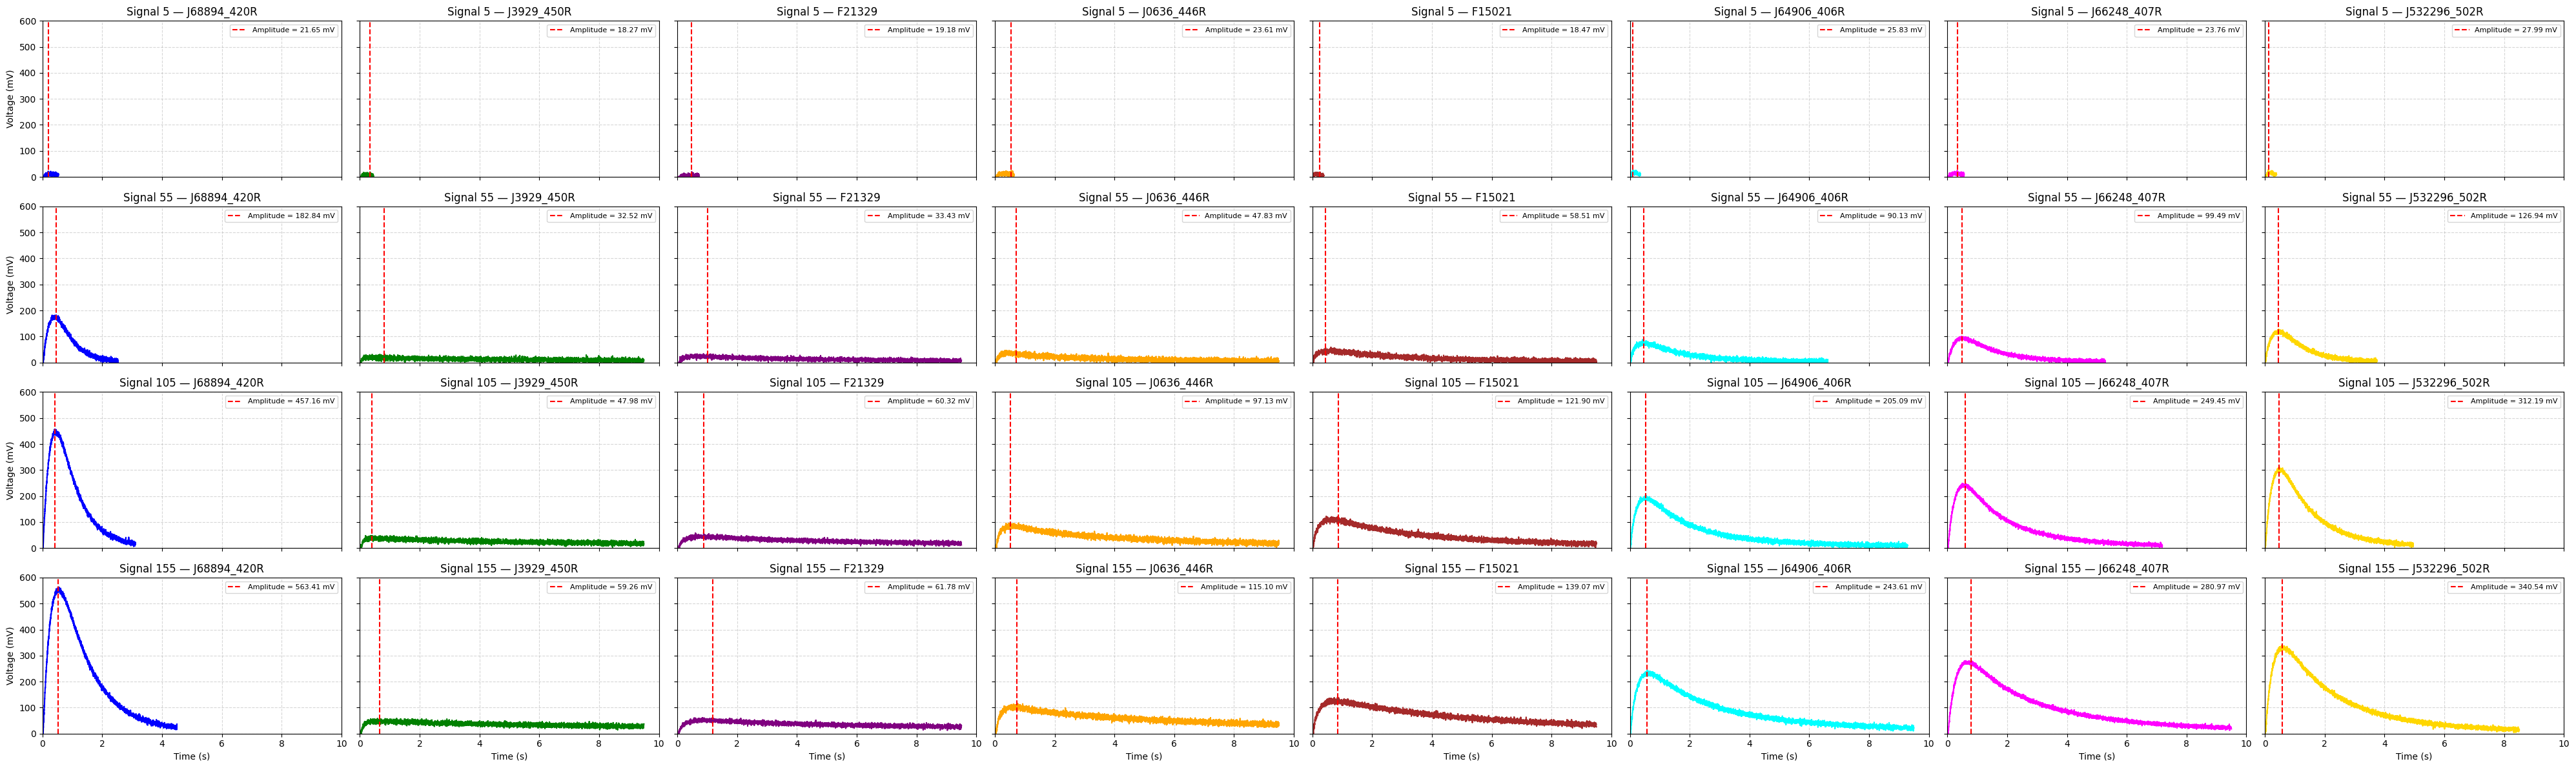

In [20]:
def plot_signals(signal_indices, signals_dict):
    """
    Plots selected signals for each sensor.

    Parameters:
        signal_indices (list[int]): Signal IDs to plot.
        signals_dict (dict[str, pd.DataFrame]): Dictionary mapping sensor IDs to their signal DataFrames.
    """
    n_signals = len(signal_indices)
    n_sensors = len(signals_dict)

    fig, axes = plt.subplots(
        n_signals, n_sensors,
        figsize=(5 * n_sensors, 3 * n_signals),
        sharex=True, sharey=True
    )

    # Ensure axes is always 2D
    if n_signals == 1 and n_sensors == 1:
        axes = np.array([[axes]])
    elif n_signals == 1:
        axes = axes.reshape(1, -1)
    elif n_sensors == 1:
        axes = axes.reshape(-1, 1)

    colors = ['blue', 'green', 'purple', 'orange', 'brown', 'cyan', 'magenta', 'gold']

    for i, sig_id in enumerate(signal_indices):
        for j, (sensor_name, df) in enumerate(signals_dict.items()):
            data = df[df['sig'] == sig_id]
            if data.empty:
                continue  # Skip if no data for this signal ID

            t = data['t']
            y = data['y']

            amplitude = np.max(y)
            amplitude_time = t.iloc[np.argmax(y)]

            ax = axes[i, j]
            ax.plot(t, y, color=colors[j % len(colors)])
            ax.axvline(x=amplitude_time, color='red', linestyle='--',
                       label=f'Amplitude = {amplitude:.2f} mV')

            ax.set_xlim(0, 10)
            ax.set_ylim(0, 600)
            ax.set_title(f'Signal {sig_id} — {sensor_name}')
            ax.legend(fontsize=8)
            ax.grid(True, linestyle='--', alpha=0.5)

            if j == 0:
                ax.set_ylabel('Voltage (mV)')
            if i == n_signals - 1:
                ax.set_xlabel('Time (s)')

    plt.tight_layout()

    # Save plot with all signal IDs in filename
    # sig_str = "_".join(map(str, signal_indices))
    # plt.savefig(f'plots/signals_{sig_str}.png', dpi=300, bbox_inches='tight')
    plt.show()


# Example usage:
plot_signals([5, 55, 105, 155], signals)

### 2.4 Deviations

In [21]:
max_abs_error = 0.02   # mg/L absolute error threshold
max_rel_error = 5      # % relative error threshold

# Loop over sensors in the dataset
for sensor in sorted(data['sensor'].unique()):
    data_sensor = data[data['sensor'] == sensor]
    
    print(f"\n{'=' * 25} Sensor {sensor} {'=' * 25}")

    # Loop over unique concentration levels for this sensor
    for conc in sorted(data_sensor['conc'].unique()):
        conc_measured = data_sensor[data_sensor['conc'] == conc]['conc_measured'].to_numpy()
        
        print(f"\nConcentration: {conc:.3f} mg/L")
        print(f"Measured values: {', '.join(f'{val:.3f}' for val in conc_measured)}")
        
        # Standard deviation & relative STD
        std = np.std(conc_measured, ddof=1)
        rstd = std / np.mean(conc_measured) * 100

        print(f"→ Standard Deviation: {std:.4f}")
        print(f"→ Relative Standard Deviation: {rstd:.2f}%")

        # Validate STD
        if conc < 0.2:
            threshold = max_abs_error / 3
            valid_std = std < threshold
            print(f"{'✓ Valid' if valid_std else '✗ Invalid'} (Abs. STD): {std:.4f} < {threshold:.4f}")
        else:
            threshold = max_rel_error / 3
            valid_std = rstd < threshold
            print(f"{'✓ Valid' if valid_std else '✗ Invalid'} (Rel. STD): {rstd:.2f}% < {threshold:.2f}%")

        # RMSE (absolute & relative)
        rmse_abs = np.sqrt(mean_squared_error(conc_measured, np.full(conc_measured.shape, conc)))
        rmse_rel = rmse_abs / conc * 100

        print(f"→ Absolute RMSE: {rmse_abs:.4f}")
        print(f"→ Relative RMSE: {rmse_rel:.2f}%")

        # Validate RMSE
        if conc < 0.2:
            threshold = max_abs_error / 3
            valid_rmse = rmse_abs < threshold
            print(f"{'✓ Valid' if valid_rmse else '✗ Invalid'} (Abs. RMSE): {rmse_abs:.4f} < {threshold:.4f}")
        else:
            threshold = max_rel_error / 3
            valid_rmse = rmse_rel < threshold
            print(f"{'✓ Valid' if valid_rmse else '✗ Invalid'} (Rel. RMSE): {rmse_rel:.2f}% < {threshold:.2f}%")

    print(f"{'-' * 65}")


========================= Sensor F15021 =========================

Concentration: 0.150 mg/L
Measured values: 0.137, 0.144, 0.142, 0.144, 0.145, 0.148, 0.148, 0.149, 0.149, 0.150, 0.148, 0.148, 0.145, 0.147, 0.147, 0.149, 0.146, 0.150, 0.152, 0.150, 0.150, 0.148, 0.149, 0.143, 0.145, 0.150, 0.147, 0.149, 0.149, 0.148, 0.147, 0.148, 0.149, 0.148, 0.149, 0.150, 0.152, 0.146, 0.130, 0.146, 0.149, 0.144, 0.146, 0.149, 0.147, 0.145, 0.148, 0.149, 0.149, 0.144
→ Standard Deviation: 0.0037
→ Relative Standard Deviation: 2.52%
✓ Valid (Abs. STD): 0.0037 < 0.0067
→ Absolute RMSE: 0.0047
→ Relative RMSE: 3.14%
✓ Valid (Abs. RMSE): 0.0047 < 0.0067

Concentration: 0.475 mg/L
Measured values: 0.445, 0.467, 0.468, 0.472, 0.483, 0.478, 0.477, 0.475, 0.477, 0.493, 0.475, 0.477, 0.477, 0.478, 0.485, 0.482, 0.485, 0.467, 0.473, 0.479, 0.486, 0.481, 0.489, 0.482, 0.487, 0.485, 0.487, 0.474, 0.478, 0.481, 0.483, 0.484, 0.478, 0.483, 0.479, 0.493, 0.481, 0.485, 0.487, 0.479, 0.490, 0.477, 0.486, 0.489, 0.